# **Skenario 2 - CNN ResNet50**

Skenario 2 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur ResNet50 untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Import beberapa pustaka seperti `NumPy`, `Pandas`, `Seaborn`, `Matplotlib`, dan `Scikit-learn` untuk analisis data, serta menggunakan `TensorFlow` dan `Keras` untuk mengimplementasikan model deep learning.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Scikit-learn 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# TensorFlow and Keras imports
import tensorflow as tf
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data

Load data dari image_selected.npz 

In [2]:
def load_and_preprocess_data(preprocess_images=True):
    # Direktori tempat file NPZ disimpan
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Muat data dari file NPZ
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Daftar untuk data input (X) dan output (Y)
    X = []
    Y = []

    # Buat pemetaan label u/ tiap kelas
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterasi melalui data yang diload
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, original_slice = selected_slice

                if preprocess_images:
                    # Perluas dimensi dan ulangi untuk representasi RGB
                    original_slice = np.expand_dims(original_slice, axis=-1)
                    original_slice = np.repeat(original_slice, 3, axis=-1)

                    # Penskalaan Min-Max untuk membawa nilai piksel ke dalam rentang [0, 1]
                    min_val = np.min(original_slice)
                    max_val = np.max(original_slice)
                    original_slice = (original_slice - min_val) / (max_val - min_val)

                X.append(original_slice)
                Y.append(label_mapping[label])

    # Konversi daftar menjadi array NumPy
    X = np.array(X) 
    Y = np.array(Y, dtype=int)  # Konversi label menjadi bilangan bulat

    return X, Y


In [3]:
# Panggil fungsi dan simpan ke X, Y
X, Y = load_and_preprocess_data(preprocess_images=True)

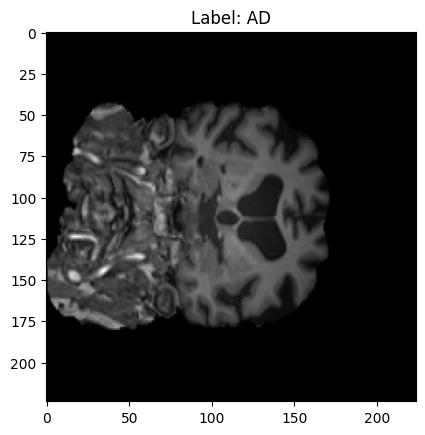

In [4]:
index_to_visualize = 0
image_to_visualize = X[index_to_visualize]
label_to_visualize = Y[index_to_visualize]

class_names = {0: 'AD', 1: 'CN', 2: 'EMCI', 3: 'LMCI'}
label_to_visualize = class_names[np.argmax(label_to_visualize)]

plt.imshow(image_to_visualize)
plt.title(f"Label: {label_to_visualize}")
plt.imshow(image_to_visualize, cmap='gray')

### 2.2 Pembagian Data
Data dibagi dengan rasio 80:20 

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cek shape dan jumlah data

In [6]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224, 3)
Dimensi Y_train: (5760,)
Dimensi X_test: (1440, 224, 224, 3)
Dimensi Y_test: (1440,)


## 3. Buat dan Konfigurasi Model
Arsitektur yang digunakan yaitu ResNet50 sebagai bagian dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [7]:
def create_model(input_shape=(224, 224, 3)):
    # Use ResNet50 as a layer in your model
    base_model = ResNet50(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False
    )

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    # Freeze all layers in the base_model
    for layer in base_model.layers:
        layer.trainable = False

    # Compile model with optimizer and loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = create_model()
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24638852 (93.99 MB)
Trainable params: 1051140 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


mendefinisikan dua fungsi, specificity dan sensitivity

In [8]:
import keras.backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', specificity, sensitivity])

## 4. Training Model

Inisialisasi `StratifiedKFold` dengan 5 lipatan, dan mengatur callback `Early Stopping `dan `Model Checkpoint` untuk digunakan selama pelatihan model

In [9]:
n_splits = 5 
# Inisialisasi StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)  

# Tentukan callback Early Stopping dan Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(r'D:\Users\RESA\Coding\Model\M_ResNet50.h5', monitor='val_loss', save_best_only=True)

Melatih dan mengevaluasi model pada setiap lipatan (fold) menggunakan `Stratified K-Fold cross-validation`, menyimpan metrik hasil evaluasi 

In [10]:
# List untuk menyimpan metrik dan riwayat model untuk setiap fold
accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_score_per_fold = []
roc_auc_per_fold = []
model_history_per_fold = []

for fold, (train_index, test_index) in enumerate(skf.split(X, Y)):
    print(f"Training on Fold: {fold+1}/{n_splits}...")

    # Split data menjadi data train dan test untuk setiap fold
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Buat model untuk setiap fold
    model = create_model()

    # Latih model dengan menggunakan Early Stopping dan Model Checkpoint callbacks
    history = model.fit(
        X_train, to_categorical(Y_train, num_classes=len(set(Y))),
        epochs=25, batch_size=32,
        validation_data=(X_test, to_categorical(Y_test, num_classes=len(set(Y)))),
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluasi model pada data test untuk setiap lipatan
    Y_test_pred = model.predict(X_test)
    Y_test_pred_classes = np.argmax(Y_test_pred, axis=1)

    # Hitung metrik
    accuracy_per_fold.append(accuracy_score(Y_test, Y_test_pred_classes))
    precision_per_fold.append(precision_score(Y_test, Y_test_pred_classes, average='weighted'))
    recall_per_fold.append(recall_score(Y_test, Y_test_pred_classes, average='weighted'))
    f1_score_per_fold.append(f1_score(Y_test, Y_test_pred_classes, average='weighted'))

    # Label biner menggunakan LabelBinarizer
    lb = LabelBinarizer()
    Y_test_binary = lb.fit_transform(Y_test)
    Y_test_pred_binary = lb.transform(Y_test_pred_classes)

    # Hitung ROC AUC untuk setiap kelas
    roc_auc_fold = []
    for i in range(len(lb.classes_)):
        fpr, tpr, _ = roc_curve(Y_test_binary[:, i], Y_test_pred_binary[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_fold.append(roc_auc)

    roc_auc_per_fold.append(roc_auc_fold)

    model_history_per_fold.append(history)

    # Cetak laporan klasifikasi untuk setiap lipatan
    classification_rep = classification_report(Y_test, Y_test_pred_classes)
    print(f"Laporan Klasifikasi untuk Lipatan {fold+1}:\n{classification_rep}")

Training on Fold: 1/5...
Epoch 1/25


180/180 [==============================] - ETA: 0s - loss: 1.4567 - accuracy: 0.2644

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 160s 876ms/step - loss: 1.4567 - accuracy: 0.2644 - val_loss: 1.4046 - val_accuracy: 0.2785
Epoch 2/25
180/180 [==============================] - 160s 890ms/step - loss: 1.4016 - accuracy: 0.2842 - val_loss: 1.3716 - val_accuracy: 0.2903
Epoch 3/25
180/180 [==============================] - 159s 887ms/step - loss: 1.3795 - accuracy: 0.2979 - val_loss: 1.3552 - val_accuracy: 0.3417
Epoch 4/25
180/180 [==============================] - 154s 856ms/step - loss: 1.3708 - accuracy: 0.3038 - val_loss: 1.3567 - val_accuracy: 0.3313
Epoch 5/25
180/180 [==============================] - 154s 859ms/step - loss: 1.3708 - accuracy: 0.3108 - val_loss: 1.3665 - val_accuracy: 0.2729
Epoch 6/25
180/180 [==============================] - 160s 888ms/step - loss: 1.3604 - accuracy: 0.3220 - val_loss: 1.3520 - val_accuracy: 0.3201
Epoch 7/25
180/180 [==============================] - 154s 855ms/step - loss: 1.3562 - accuracy: 0.3161 - val_loss: 1.3644 - val_accura

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 167s 927ms/step - loss: 1.3531 - accuracy: 0.3234 - val_loss: 1.3510 - val_accuracy: 0.3410
Epoch 9/25
180/180 [==============================] - 167s 928ms/step - loss: 1.3531 - accuracy: 0.3286 - val_loss: 1.3729 - val_accuracy: 0.3090
Epoch 10/25
180/180 [==============================] - 165s 916ms/step - loss: 1.3477 - accuracy: 0.3340 - val_loss: 1.3640 - val_accuracy: 0.2910
Epoch 11/25
180/180 [==============================] - 159s 886ms/step - loss: 1.3599 - accuracy: 0.3130 - val_loss: 1.3705 - val_accuracy: 0.2743
Epoch 12/25
180/180 [==============================] - 156s 870ms/step - loss: 1.3565 - accuracy: 0.3229 - val_loss: 1.3630 - val_accuracy: 0.2646
Epoch 13/25
180/180 [==============================] - 162s 899ms/step - loss: 1.3463 - accuracy: 0.3363 - val_loss: 1.3486 - val_accuracy: 0.3347
Epoch 14/25
180/180 [==============================] - 159s 887ms/step - loss: 1.3491 - accuracy: 0.3300 - val_loss: 1.3531 - val_a

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

Epoch 1/25
180/180 [==============================] - 161s 880ms/step - loss: 1.4361 - accuracy: 0.2762 - val_loss: 1.4592 - val_accuracy: 0.2882
Epoch 2/25
180/180 [==============================] - 157s 873ms/step - loss: 1.4007 - accuracy: 0.2828 - val_loss: 1.3698 - val_accuracy: 0.2688
Epoch 3/25
180/180 [==============================] - 156s 866ms/step - loss: 1.3923 - accuracy: 0.2818 - val_loss: 1.3686 - val_accuracy: 0.2937
Epoch 4/25
180/180 [==============================] - 159s 884ms/step - loss: 1.3642 - accuracy: 0.3118 - val_loss: 1.3553 - val_accuracy: 0.3326
Epoch 5/25
180/180 [==============================] - 156s 866ms/step - loss: 1.3695 - accuracy: 0.3101 - val_loss: 1.3805 - val_accuracy: 0.2660
Epoch 6/25
180/180 [==============================] - 156s 869ms/step - loss: 1.3671 - accuracy: 0.3043 - val_loss: 1.3595 - val_accuracy: 0.3187
Epoch 7/25
180/180 [==============================] - 158s 877ms/step - loss: 1.3657 - accuracy: 0.3042 - val_loss: 1.3543 -

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 163s 905ms/step - loss: 1.3487 - accuracy: 0.3318 - val_loss: 1.3381 - val_accuracy: 0.3444
Epoch 13/25
180/180 [==============================] - 159s 885ms/step - loss: 1.3497 - accuracy: 0.3297 - val_loss: 1.3425 - val_accuracy: 0.3444
Epoch 14/25
180/180 [==============================] - 162s 904ms/step - loss: 1.3447 - accuracy: 0.3332 - val_loss: 1.3338 - val_accuracy: 0.3438
Epoch 15/25
180/180 [==============================] - 157s 874ms/step - loss: 1.3391 - accuracy: 0.3363 - val_loss: 1.3474 - val_accuracy: 0.3063
Epoch 16/25
180/180 [==============================] - 165s 918ms/step - loss: 1.3372 - accuracy: 0.3385 - val_loss: 1.3311 - val_accuracy: 0.3583
Epoch 17/25
180/180 [==============================] - 165s 918ms/step - loss: 1.3364 - accuracy: 0.3424 - val_loss: 1.3273 - val_accuracy: 0.3701
Epoch 18/25
180/180 [==============================] - 157s 873ms/step - loss: 1.3376 - accuracy: 0.3392 - val_loss: 1.3967 - val_

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 163s 908ms/step - loss: 1.3357 - accuracy: 0.3408 - val_loss: 1.3095 - val_accuracy: 0.3750
Epoch 25/25
45/45 [==============================] - 32s 704ms/step
Laporan Klasifikasi untuk Lipatan 4:
              precision    recall  f1-score   support

           0       0.45      0.46      0.45       360
           1       0.28      0.32      0.30       360
           2       0.43      0.56      0.49       360
           3       0.39      0.20      0.27       360

    accuracy                           0.39      1440
   macro avg       0.39      0.39      0.38      1440
weighted avg       0.39      0.39      0.38      1440

Training on Fold: 5/5...
Epoch 1/25
180/180 [==============================] - 164s 897ms/step - loss: 1.4399 - accuracy: 0.2681 - val_loss: 1.4133 - val_accuracy: 0.2604
Epoch 2/25
180/180 [==============================] - 159s 882ms/step - loss: 1.3913 - accuracy: 0.2896 - val_loss: 1.3637 - val_accuracy: 0.3278
Epoch 3/

## 4. Testing

Test Data

In [11]:
evaluation_result = model.evaluate(X_test, to_categorical(Y_test, num_classes=4), verbose=1)

# Menampilkan hasil evaluasi
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

# Prediksi menggunakan data uji
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

print('Label Sebenarnya : ', Y_test)
print('Label Prediksi : ', predicted_labels)

45/45 [==============================] - 31s 699ms/step - loss: 1.3218 - accuracy: 0.3674
Loss: 1.3218395709991455
Accuracy: 0.3673610985279083
45/45 [==============================] - 31s 693ms/step
Label Sebenarnya :  [0 0 0 ... 3 3 3]
Label Prediksi :  [0 0 0 ... 0 2 2]


## 5. Evaluasi dan Visualisasi

Evaluasi model yang telah diuji

In [12]:
# Find the fold with the best validation loss
best_fold = np.argmin([history.history['val_loss'][-1] for history in model_history_per_fold])

# Retrieve the model with the best performance
best_model = create_model()
best_model.set_weights(model_history_per_fold[best_fold].model.get_weights())

# Evaluate the best model on the validation set
Y_test_pred_best = best_model.predict(X_test)
Y_test_pred_classes_best = np.argmax(Y_test_pred_best, axis=1)

45/45 [==============================] - 32s 690ms/step


classification report

In [13]:
classification_rep_best = classification_report(Y_test, Y_test_pred_classes_best)
print(f"Best Model - Classification Report:\n{classification_rep_best}")

Best Model - Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.44      0.45       360
           1       0.25      0.31      0.28       360
           2       0.37      0.45      0.41       360
           3       0.35      0.21      0.26       360

    accuracy                           0.35      1440
   macro avg       0.36      0.35      0.35      1440
weighted avg       0.36      0.35      0.35      1440



confusion matrix

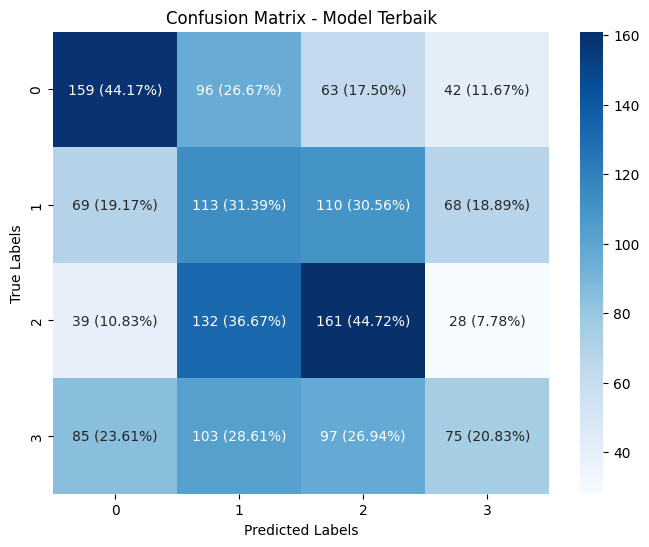

In [14]:
# Hitung confusion matrix u/ model terbaik
conf_matrix_best = confusion_matrix(Y_test, Y_test_pred_classes_best)

# Normalisasi confusion matrux untuk mendapatkan persentase
conf_matrix_percentage = conf_matrix_best.astype('float') / conf_matrix_best.sum(axis=1)[:, np.newaxis]

# Buat anotasi kustom
annotations = [['{} ({:.2%})'.format(value, percentage) for value, percentage in zip(row, row_percentage)]
               for row, row_percentage in zip(conf_matrix_best, conf_matrix_percentage)]

# Plot conf matrix dgn anotasi kustom
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=annotations, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Model Terbaik')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [15]:
# Jmlh kelas dalam data test
num_classes = len(set(Y_test))

# List untuk nyimpen sensitivitas dan spesifisitas /kelas
sensitivity = []
specificity = []

# Iterasi untuk tiap kelas
for i in range(num_classes):
    # True Positive (tp), False Negative (fn), False Positive (fp), True Negative (tn)
    tp = conf_matrix_best[i, i]
    fn = np.sum(conf_matrix_best[i, :]) - tp
    fp = np.sum(conf_matrix_best[:, i]) - tp
    tn = np.sum(conf_matrix_best) - tp - fn - fp

    # Hitung sensitivitas & spesifisitas
    sensitivity.append(tp / (tp + fn))
    specificity.append(tn / (tn + fp))

print("Sensitivitas per kelas:", sensitivity)
print("Spesifisitas per kelas:", specificity)


Sensitivitas per kelas: [0.44166666666666665, 0.3138888888888889, 0.44722222222222224, 0.20833333333333334]
Spesifisitas per kelas: [0.8212962962962963, 0.6935185185185185, 0.75, 0.8722222222222222]


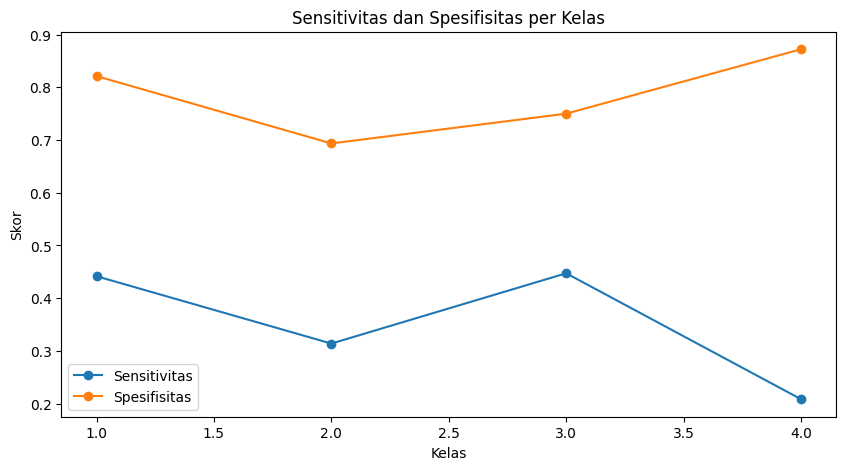

In [16]:
# Jmlh kelas yg digunakan
num_classes = len(sensitivity)

# Plotting sensitivitas dan spesifisitas pd grafik yang sama
plt.figure(figsize=(10, 5))

# Plot sensitivitas
plt.plot(range(1, num_classes + 1), sensitivity, marker='o', linestyle='-', label='Sensitivitas')

# Plot spesifisitas
plt.plot(range(1, num_classes + 1), specificity, marker='o', linestyle='-', label='Spesifisitas')

plt.title('Sensitivitas dan Spesifisitas per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Skor')
plt.legend()
plt.show()

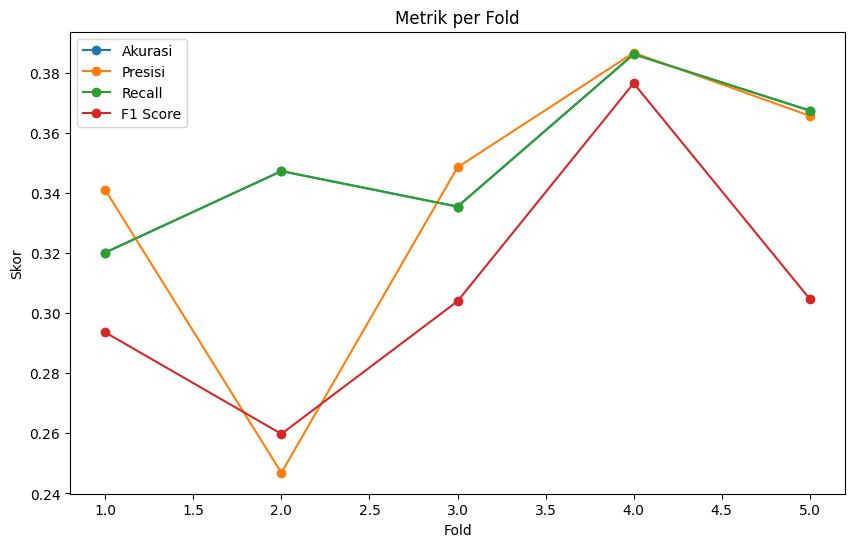

In [17]:
# Jumlah lipatan yang digunakan
n_folds = len(accuracy_per_fold)

# Plot semua metrik dlm satu grafik
plt.figure(figsize=(10, 6))

# Plot akurasi
plt.plot(range(1, n_folds + 1), accuracy_per_fold, marker='o', label='Akurasi')

# Plot presisi
plt.plot(range(1, n_folds + 1), precision_per_fold, marker='o', label='Presisi')

# Plot recall
plt.plot(range(1, n_folds + 1), recall_per_fold, marker='o', label='Recall')

# Plot F1 score
plt.plot(range(1, n_folds + 1), f1_score_per_fold, marker='o', label='F1 Score')

plt.title('Metrik per Fold')
plt.xlabel('Fold')
plt.ylabel('Skor')
plt.legend()
plt.show()

In [18]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

In [19]:
for fold, roc_auc_fold in enumerate(roc_auc_per_fold):
    for i, auc_value in enumerate(roc_auc_fold):
        print(f"ROC AUC untuk Lipatan {fold+1}, Kelas {class_names[i]}: {auc_value}")

ROC AUC untuk Lipatan 1, Kelas AD: 0.6175925925925926
ROC AUC untuk Lipatan 1, Kelas CN: 0.49259259259259264
ROC AUC untuk Lipatan 1, Kelas EMCI: 0.5587962962962963
ROC AUC untuk Lipatan 1, Kelas LMCI: 0.5180555555555555
ROC AUC untuk Lipatan 2, Kelas AD: 0.6111111111111112
ROC AUC untuk Lipatan 2, Kelas CN: 0.5
ROC AUC untuk Lipatan 2, Kelas EMCI: 0.6416666666666666
ROC AUC untuk Lipatan 2, Kelas LMCI: 0.5064814814814814
ROC AUC untuk Lipatan 3, Kelas AD: 0.6643518518518517
ROC AUC untuk Lipatan 3, Kelas CN: 0.513888888888889
ROC AUC untuk Lipatan 3, Kelas EMCI: 0.5296296296296297
ROC AUC untuk Lipatan 3, Kelas LMCI: 0.5199074074074074
ROC AUC untuk Lipatan 4, Kelas AD: 0.6361111111111111
ROC AUC untuk Lipatan 4, Kelas CN: 0.524074074074074
ROC AUC untuk Lipatan 4, Kelas EMCI: 0.6550925925925926
ROC AUC untuk Lipatan 4, Kelas LMCI: 0.5476851851851852
ROC AUC untuk Lipatan 5, Kelas AD: 0.6453703703703703
ROC AUC untuk Lipatan 5, Kelas CN: 0.5217592592592594
ROC AUC untuk Lipatan 5, Kel

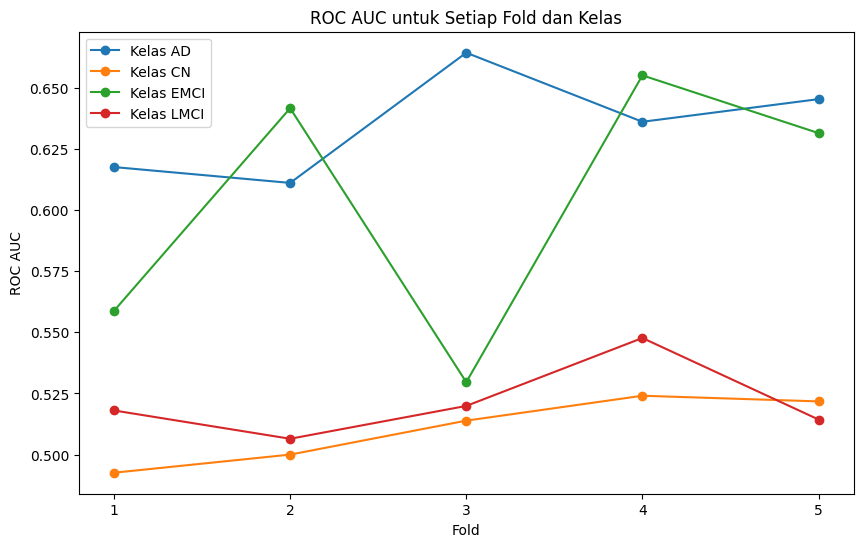

In [20]:
n_folds = len(roc_auc_per_fold)
n_classes = len(class_names)

# Data untuk plotting
data = np.array(roc_auc_per_fold)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Membuat garis untuk setiap kelas
for i in range(n_classes):
    ax.plot(range(1, n_folds + 1), data[:, i], marker='o', label=f'Kelas {class_names[i]}')

ax.set_xlabel('Fold')
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC untuk Setiap Fold dan Kelas')
ax.set_xticks(range(1, n_folds + 1)) 
ax.legend()

plt.show()

In [21]:
# Cetak average ROC AUC
average_roc_auc = np.mean(roc_auc_per_fold)
print(f'Average ROC AUC: {average_roc_auc:.2f}')

Average ROC AUC: 0.57


In [25]:
all_train_loss = []
all_val_loss = []

# Loop untuk setiap fold
for fold in range(n_splits):
    # Dapatkan objek history untuk fold tertentu
    history = model_history_per_fold[fold]

    # Gabungkan data loss dari setiap epoch untuk setiap fold
    all_train_loss.extend(history.history['loss'])
    all_val_loss.extend(history.history['val_loss'])

In [27]:
# Cetak loss dan val_loss yang telah digabungkan dari semua fold
print("All Train Loss:")
print(all_train_loss)

print("\nAll Val Loss:")
print(all_val_loss)

All Train Loss:
[1.4566566944122314, 1.401616096496582, 1.3794958591461182, 1.3707911968231201, 1.3708447217941284, 1.3604168891906738, 1.3562486171722412, 1.3669757843017578, 1.3557393550872803, 1.350643277168274, 1.3472537994384766, 1.4633965492248535, 1.3921653032302856, 1.3728415966033936, 1.3693430423736572, 1.3735748529434204, 1.361871600151062, 1.3559322357177734, 1.3531125783920288, 1.353109359741211, 1.3477240800857544, 1.3598716259002686, 1.3565422296524048, 1.346275806427002, 1.3491151332855225, 1.3451693058013916, 1.3451043367385864, 1.339945673942566, 1.3343738317489624, 1.337619423866272, 1.3324830532073975, 1.340774416923523, 1.3350965976715088, 1.436075210571289, 1.4007127285003662, 1.392270565032959, 1.3642264604568481, 1.3694533109664917, 1.3671330213546753, 1.3657091856002808, 1.3608933687210083, 1.3601336479187012, 1.366005539894104, 1.356105923652649, 1.3487166166305542, 1.3496705293655396, 1.344714879989624, 1.3390849828720093, 1.3371621370315552, 1.33641898632049

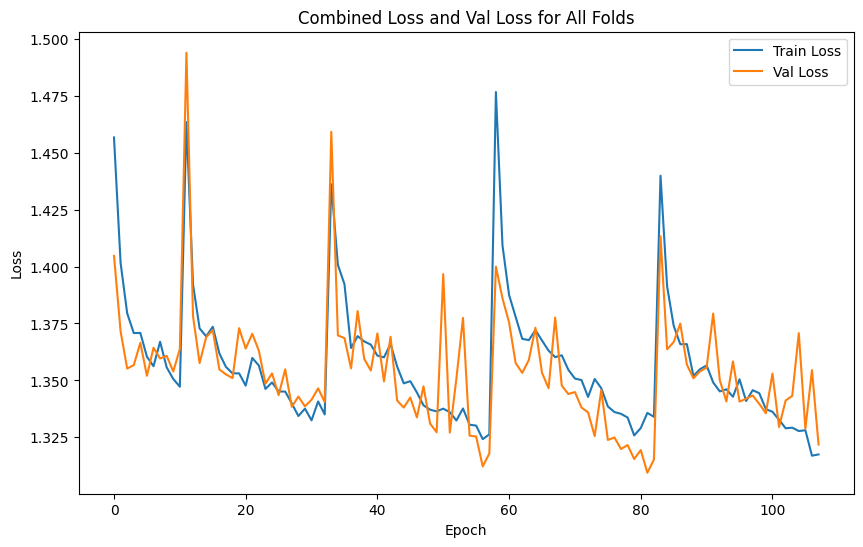

In [26]:
# Plot loss dan val_loss untuk semua fold
plt.figure(figsize=(10, 6))
plt.plot(all_train_loss, label='Train Loss')
plt.plot(all_val_loss, label='Val Loss')
plt.title('Combined Loss and Val Loss for All Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()